In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
import numpy as np
import matplotlib.pyplot as plt
from lens import bessel
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy import integrate

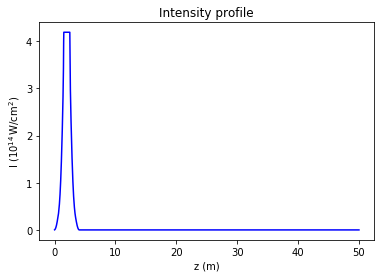

0.0


In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 10000
Iz, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

plt.plot(Iz/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()
print(I[N-1])

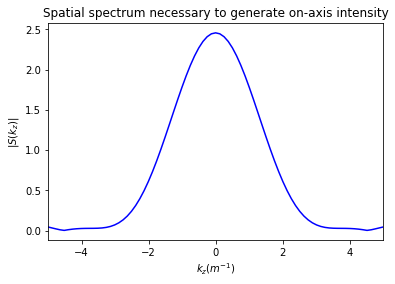

In [3]:
# First what is the spatial spectrum with 0 phase on the entire output
lam = 0.8
k = 2*np.pi/lam

S = fftshift(fft(ionization.field_from_intensity(I)))/N
kz = fftshift(fftfreq(np.size(Iz), Iz[1]-Iz[0]))*2*np.pi
#kr = np.sqrt(k**2 - kz**2)
plt.plot(kz*1e6, abs(S), 'b-')
plt.xlabel(r'$k_z (m^{-1})$')
plt.ylabel(r'$|S(k_z)|$')
plt.title('Spatial spectrum necessary to generate on-axis intensity')
plt.xlim([-5, 5])
plt.show()

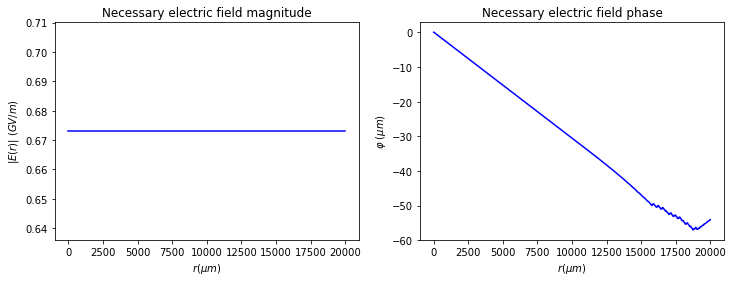

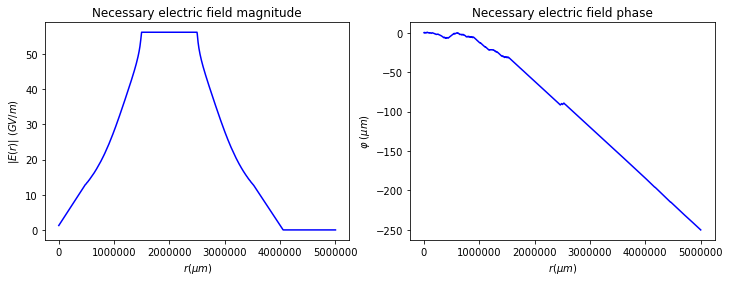

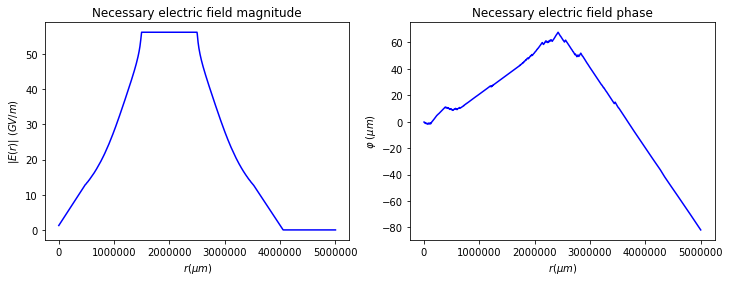

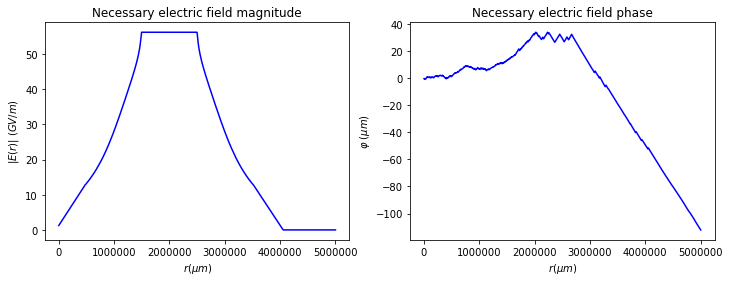

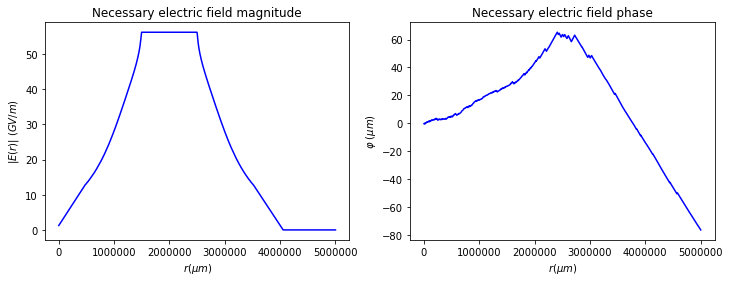

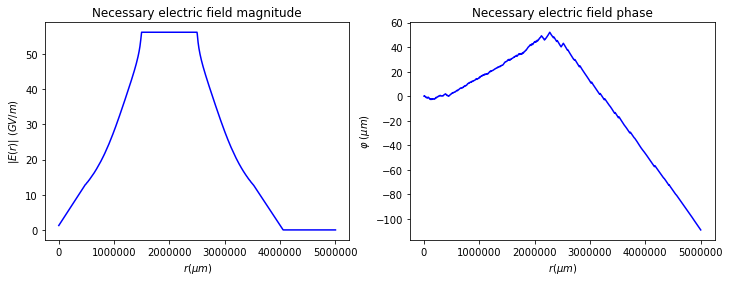

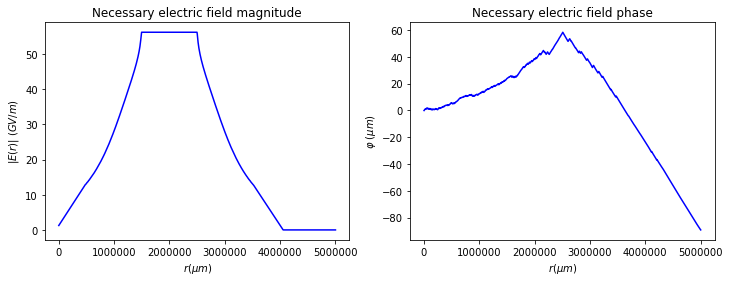

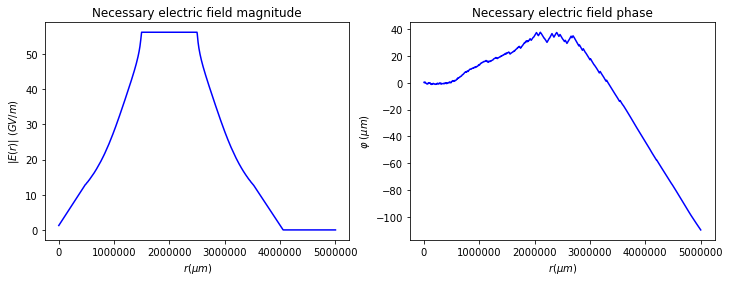

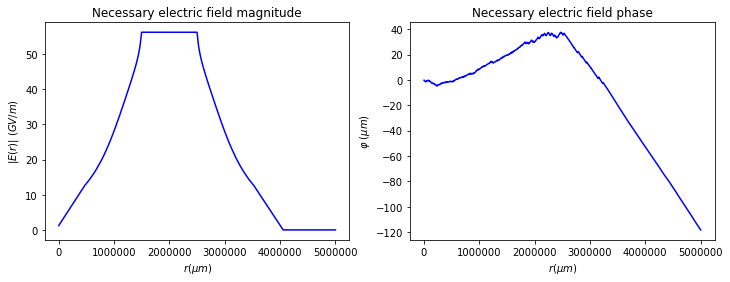

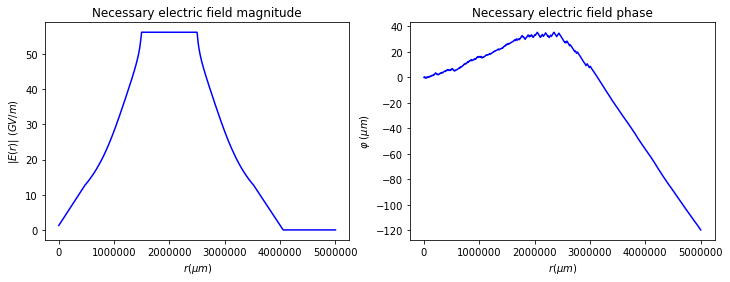

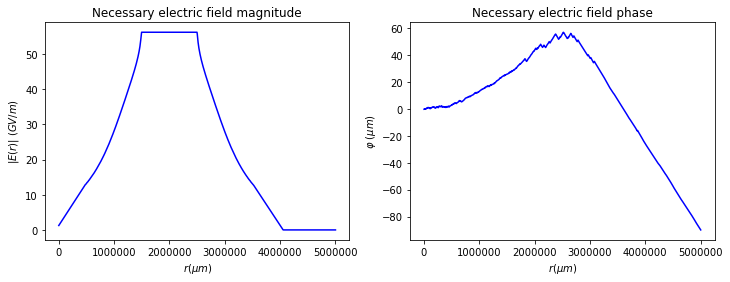

In [76]:
# Attempt essentially a G-S algorithm for phase since we can go both directions
params = {'N' : 1000,
          'M' : 1000,
          'R' : 0.1e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
# Remove the zeros from the intensity distribution and set everything up
Ez = ionization.field_from_intensity(I[1:])
magEz = abs(Ez)
z = Iz[1:]
r, Er = bessel.uniform_bessel(params, Ez, z)
Er = Er*1e6
magEr = np.ones(params['M'])*np.sum(abs(Er))/params['M']
phi = np.unwrap(np.angle(Er))
Er = magEr * np.exp(1j*np.unwrap(np.angle(Er)))
a = 1000
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(r, abs(Er), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')

plt.subplot(122)
plt.plot(r, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

# G-S algorithm
for i in range(0,10):
    Ez = laser.fresnel_axis(Er, r, z, params['lam'])
    phi = np.unwrap(np.angle(Ez))
    Ez = magEz * np.exp(1j*np.unwrap(np.angle(Ez)))
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.plot(z[0:a], abs(Ez[0:a]), 'b-')
    plt.xlabel(r'$r (\mu m)$')
    plt.ylabel(r'$|E(r)|$ $(GV/m)$')
    plt.title(r'Necessary electric field magnitude')

    plt.subplot(122)
    plt.plot(z[0:a], phi[0:a]/k, 'b-')
    plt.xlabel(r'$r (\mu m)$')
    plt.ylabel(r'$\varphi$ ($\mu m$)')
    plt.title(r'Necessary electric field phase')
    plt.show()
    
    r, Er = bessel.uniform_bessel(params, Ez, z)
    Er = magEr * np.exp(1j*np.unwrap(np.angle(Er)))

e = laser.fresnel_axis(Er, r, z, params['lam'])
IFres = ionization.intensity_from_field(abs(e))
Itot = integrate.simps(ionization.intensity_from_field(Ez), z)
Iact = integrate.simps(IFres, z)
#IFres = IFres * (Itot/Iact)

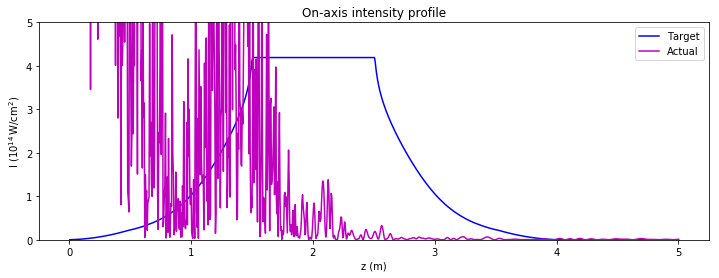

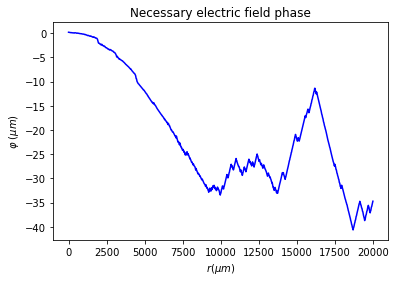

0.644761223748


In [71]:
a = 1000
plt.figure(figsize={12, 4})
plt.plot(z[0:a]/1e6, I[0:a], 'b-', z[0:a]/1e6, IFres[0:a], 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.ylim([0,5])
plt.show()

phi = np.unwrap(np.angle(Er))
plt.plot(r, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

print(magEr[1])